# Kaggle : New York City Taxi Trip Duration

# 1 EDA (Exploratory Data Analysis)

## 1.1 Data 탐색

In [2]:
from IPython.display import display
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Distance
from math import sin, cos, sqrt, atan2, radians

# Map
import seaborn as sns
import ipyleaflet
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster     
from geographiclib.geodesic import Geodesic  

# time/day data
import time, datetime                        
import calendar


# Regeression
import scipy
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.preprocessing import normalize
import statsmodels

%matplotlib inline

### 1.1.1 Data Road

In [3]:
train = pd.read_csv("train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
test = pd.read_csv("test.csv")
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


### 1.1.2 Column Information

1. id : Trip별로 부여된 고유 id

2. verdor_id : Taxi Company id >>> 1, 2로 구성 (2개의 회사)

3. pickup/dropoff datetime : 출발/도착 시간정보 >>> 년, 월, 일, 시각 정보가 포함

4. passenger_count : 승객수 >>> 0~9명까지 존재

5. pickup/dropoff_longitude & latitude : 출발/도착 지리정보

   - 단위 : 111.32mm per 0.000001° / 11.132 m per 0.0001° / 1.1132 km per 0.01° 
   - 14 demical degree

6. store_and_fwd_flag : 운행 기록 전송 전에 차량 메모리 저장 (Y: 저장/전송, N: 미저장/전송)

7. trip_duration : 탑승시간 >>> 단위는 Seconds

### 1.1.3 Missing Data Check

In [7]:
#none of missing data
train2 = train.dropna(how = 'any')
test2 = test.dropna(how = 'any')
len(train) == len(train2), len(test) == len(test2)

(True, True)

### 1.1.4 Trip duration Check

In [8]:
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
train["dropoff_datetime"] =  pd.to_datetime(train["dropoff_datetime"])
sample_duration = train["dropoff_datetime"] - train["pickup_datetime"]
sample_duration_sec = sample_duration.dt.total_seconds().astype('int')
train['trip_sec'] =  sample_duration_sec

In [9]:
train_d = train[train["trip_duration"] != train["trip_sec"]]
len(train_d)

0

## 1.2 Datetime 다루기

In [10]:
#data type convert to datetime from object
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
test["pickup_datetime"] =  pd.to_datetime(test["pickup_datetime"])

In [11]:
#date by month
train["pick_dayofmonth"] = train["pickup_datetime"].dt.month
test["pick_dayofmonth"] = test["pickup_datetime"].dt.month

#day of week
#Monday=0, Sunday=6
train["pick_dayofweek"] = train["pickup_datetime"].dt.dayofweek
test["pick_dayofweek"] = test["pickup_datetime"].dt.dayofweek


# #date by hour
train["pick_datehour"] = train["pickup_datetime"].dt.hour
test["pick_datehour"] = test["pickup_datetime"].dt.hour

# 2. Feature Selection

## 2.1 Trip Duration

### 2.1.1 Trip Duration Distribution

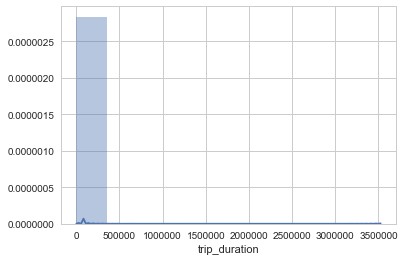

In [13]:
sns.distplot(train["trip_duration"], bins=10);
plt.xlabel('trip_duration')
plt.show()

### 2.1.2 Trip Duration Log 취함

In [14]:
train['log_duration'] = np.log1p(train['trip_duration'])
train.loc[:, 'log_duration'].tail()

1458639    6.658011
1458640    6.486161
1458641    6.639876
1458642    5.924256
1458643    5.293305
Name: log_duration, dtype: float64

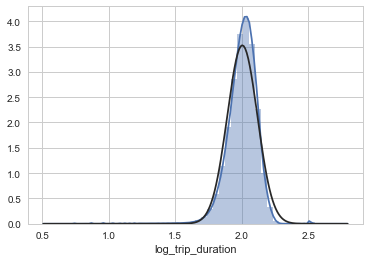

In [17]:
sns.distplot(np.log1p(train["log_duration"]), fit=sp.stats.norm)
plt.xlabel("log_trip_duration")
plt.show()

## 2.2 Date Time & Trip Duration

### 2.2.1 Month & Trip Duration

In [35]:
taxi_month = pd.DataFrame(train, columns=['vendor_id', 'pick_dayofmonth','trip_duration'])
taxi_month = taxi_month.groupby(['vendor_id', 'pick_dayofmonth']).agg('median').reset_index() 

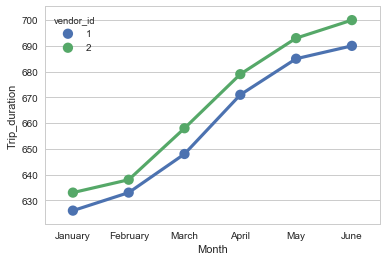

In [36]:
sns.pointplot(x=taxi_month['pick_dayofmonth'], y=taxi_month['trip_duration'], hue = taxi_month['vendor_id'], data=taxi_month)
plt.xlabel('Month')
plt.xticks(range(0,6), calendar.month_name[1:7])
plt.ylabel('Trip_duration')

plt.show()

### 2.2.2 Week & Trip Duration

In [38]:
taxi_week = pd.DataFrame(train, columns=['vendor_id', 'pick_dayofweek','trip_duration'])
taxi_week = taxi_week.groupby(['vendor_id', 'pick_dayofweek']).agg('median').reset_index() 

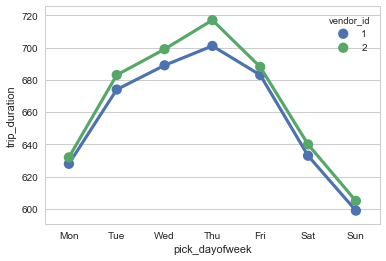

In [39]:
sns.pointplot(x=taxi_week['pick_dayofweek'], y=taxi_week['trip_duration'], hue = taxi_week['vendor_id'], data=taxi_week)
plt.xlabel('pick_dayofweek')
plt.xticks(taxi_week['pick_dayofweek'], ('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.ylabel('trip_duration')
plt.show()

### 2.2.3 hours & Trip Duration

In [40]:
taxi_time = pd.DataFrame(train, columns=['vendor_id', 'pick_datehour','trip_duration'])
taxi_time = taxi_time.groupby(['vendor_id', 'pick_datehour']).agg('median').reset_index()

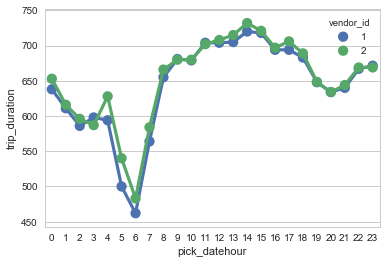

In [41]:
sns.pointplot(x=taxi_time['pick_datehour'], y=taxi_time['trip_duration'], hue = taxi_time['vendor_id'], data=taxi_time)
plt.xlabel('pick_datehour')
plt.ylabel('trip_duration')

plt.show()

## 2.2.4 시간에 따른 분류

In [45]:
bins = [0, 8, 18, 24]
group_names = ["before work", "work", "after work"]
train['work_hour'] = pd.cut(train['pick_datehour'], bins, labels=group_names, right=False)

test['work_hour'] = pd.cut(test['pick_datehour'], bins, labels=group_names, right=False)

## 2.3 Distance

### 2.3.1 Haversine Distance

In [46]:
from math import cos, asin, sqrt
def dist(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

In [47]:
# approximate radius of earth in km
# train
for i in range(len(train)):
    lat1 = train['pickup_latitude'][i]
    lon1 = train['pickup_longitude'][i]
    lat2 = train['dropoff_latitude'][i]
    lon2 = train['dropoff_longitude'][i]
    train.at[i, 'distance'] = dist(lat1, lon1, lat2, lon2)


In [48]:
# approximate radius of earth in km
# test
for i in range(len(test)):
    lat1 = test['pickup_latitude'][i]
    lon1 = test['pickup_longitude'][i]
    lat2 = test['dropoff_latitude'][i]
    lon2 = test['dropoff_longitude'][i]
    test.at[i, 'distance'] = dist(lat1, lon1, lat2, lon2)


### 2.3.2 Manhattan Distance

In [49]:
train['manhattan_distance'] = (abs(train.dropoff_longitude - train.pickup_longitude) +
                            abs(train.dropoff_latitude - train.pickup_latitude))

In [50]:
test['manhattan_distance'] = (abs(test.dropoff_longitude - test.pickup_longitude) +
                            abs(test.dropoff_latitude - test.pickup_latitude))

## 2.3.3 Direcrtion

In [51]:
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [52]:
train['bearing'] = calculate_bearing(train.pickup_latitude,
                                     train.pickup_longitude,
                                     train.dropoff_latitude,
                                     train.dropoff_longitude)


In [53]:
test['bearing'] = calculate_bearing(test.pickup_latitude,
                                     test.pickup_longitude,
                                     test.dropoff_latitude,
                                     test.dropoff_longitude)